In [1]:
from datetime import datetime, timedelta

import geopandas as gpd
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt

In [2]:
def munge_time(df, time_column):
    days_of_week = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df["year"] = pd.DatetimeIndex(df[time_column]).year
    df["month"] = pd.DatetimeIndex(df[time_column]).month
    df["hour"] = pd.DatetimeIndex(df[time_column]).hour

    df["year_month"] = df.year.astype(str) + df.month.map(
        lambda x: f"-{x:02}"
    )

    # we want our nominal day of week to end at 3 AM:
    # Sunday morning at 1 AM is pretty much Saturday night for our purposes.
    df[f"shifted_{time_column}_dow"] = pd.DatetimeIndex(df[time_column]).map(
        lambda x: x - timedelta(hours=3)
    )
    dow_type = CategoricalDtype(categories=days_of_week, ordered=True)
    df["day_of_week"] = pd.DatetimeIndex(
        df[f"shifted_{time_column}_dow"]
    ).day_name()
    df["day_of_week"] = df["day_of_week"].astype(dow_type)
    return df


In [3]:
epd = pd.read_csv(
    "epd-traffic-violence.csv",
    parse_dates=["call_time", "dispatch_time"],
    date_format="%m/%d/%Y %I:%M:%S %p",
    dtype={"event_number": str, "case": str},
)

In [4]:
epd = munge_time(epd, 'call_time')

In [11]:
epd.incident_desc.unique()

array(['Traffic Hazard', 'Traffic Stop', 'Theft from Vehicle',
       'Switched Plates', 'ATL Drunk Driver', 'Suspicious Vehicle(s)',
       'Motor Vehicle Injury', 'Reckless Driving',
       'Unauthorized Use of Vehicle', 'Hit & Run', 'Wrong Way Driver',
       'Disabled Vehicle(s)', 'Unlawful Vehicle Entry',
       'Motor Vehicle Unknown', 'Motor Vehicle No Injury',
       'Blocked Alley', 'Accident, Vehicle-Pedestrian',
       'Accident, Vehicle-Bike', 'Blocked Driveway', 'Blocked Sidewalk',
       'Traffic Signal Malfunction', 'Missing Vehicle', 'Towed Vehicle',
       'Speeding Vehicle(s)', 'Accident, Bike', 'Stop Sign Down',
       'Speeding Motorcycle(s)', 'Driving Complaint', 'Traffic Complaint',
       'DUII', 'Railroad Crossing Problem', 'Illegal Motorcycle(s)',
       'Sign Down', 'Storage on Street', 'Accident, Train Injury',
       'Driving While Suspended', 'Road Closure', 'Truck/Safety Checks',
       'Careless Driving', 'Impound Vehicle(s)',
       'Bike Skateboard Comp

In [5]:
ems = pd.read_csv('ems-traffic-violence.csv', parse_dates=['dispatch_datetime'])

In [6]:
ems = munge_time(ems, 'dispatch_datetime')

In [7]:
ems

,event_number,agency,dispatch_time,area,location,city,description,dispatch_datetime,year,month,hour,year_month,shifted_dispatch_datetime_dow,day_of_week
0,20198727,RFD,11:20:03,6SOL,S MILL ST/N PACIFIC HWY,CRE,MOTOR VEH ACC UNKNOWN INJ,2020-08-10 11:20:03,2020,8,11,2020-08,2020-08-10 08:20:03,Monday
1,20198785,RFD,12:31:06,8LFA,676 BELTLINE EB,EUG,MOTOR VEH ACC NO INJURY,2020-08-10 12:31:06,2020,8,12,2020-08,2020-08-10 09:31:06,Monday
2,20198810,RFD,13:01:49,8LFA,TERRITORIAL HWY/HWY 36,JUN,MOTOR VEH ACC UNKNOWN INJ,2020-08-10 13:01:49,2020,8,13,2020-08,2020-08-10 10:01:49,Monday
3,20198889,MTRO,14:16:09,4EUG,3890 W 11TH AVE,EUG,MOTOR VEH ACC INJURY,2020-08-10 14:16:09,2020,8,14,2020-08,2020-08-10 11:16:09,Monday
4,20198992,MTRO,15:53:34,8EUG,HWY 99N/PRAIRIE RD,EUG,MOTOR VEH ACC UNKNOWN INJ,2020-08-10 15:53:34,2020,8,15,2020-08,2020-08-10 12:53:34,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45634,23248686,MTRO,19:10:15,4EUG,W 18TH AVE/WILLAMETTE ST,EUG,MOTOR VEH ACC UNKNOWN INJ,2023-09-11 19:10:15,2023,9,19,2023-09,2023-09-11 16:10:15,Monday
45635,23248690,RFD,19:14:42,4LFA,CROW RD/ERICKSON RD,EUG,MOTOR VEH ACC UNKNOWN INJ,2023-09-11 19:14:42,2023,9,19,2023-09,2023-09-11 16:14:42,Monday
45636,23248694,MTRO,19:14:43,4LFA,CROW RD/ERICKSON RD,EUG,MOTOR VEH ACC UNKNOWN INJ,2023-09-11 19:14:43,2023,9,19,2023-09,2023-09-11 16:14:43,Monday
45637,23248700,MTRO,19:20:03,4EUG,N DANEBO AVE/BARGER DR,EUG,VEHICLE/PEDESTRIAN CRASH,2023-09-11 19:20:03,2023,9,19,2023-09,2023-09-11 16:20:03,Monday


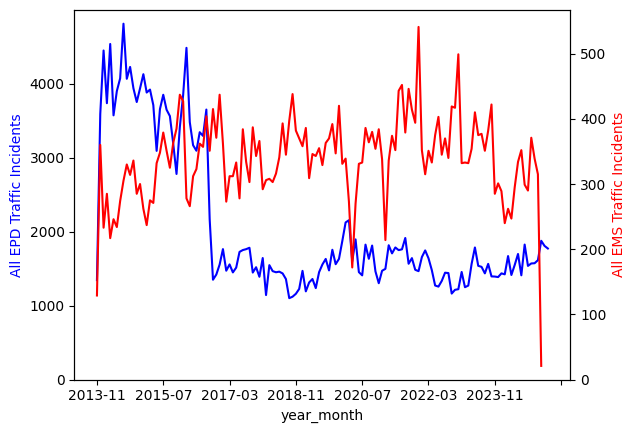

In [9]:
def epd_vs_ems_by_timeframe(epd, ems, timeframe, label, incident_type=None):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    epd.groupby(timeframe).size().plot.line(color='blue', ax=ax1)
    ems.groupby(timeframe).size().plot.line(color='red', ax=ax2)

    ax1.set_ylabel(f'{label} EPD Traffic Incidents', color='blue')
    ax2.set_ylabel(f'{label} EMS Traffic Incidents', color='red')
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)


epd_vs_ems_by_timeframe(epd, ems, 'year_month', 'All')

